# Model based on epigenetic factors
Model Parameters: create based on previous linear regression model of methylation and mRNA expression.
This includes Single Gene Methylation mRNA expression (SGMM) and 
Pair Genes Coexpression mRNA expression (PGCM)
Model Input: single test subject's measured mRNA expression and methylation across multiple genes
Model Output: list of genes with methylation/mRNA expression (in range, low methylation, high methylation)

In [85]:
# data source: http://www.cbioportal.org/index.do?session_id=59dbf8f6498e5df2e29663ab&show_samples=false&clinicallist=NO_CONTEXT_MUTATION_SIGNATURE,AJCC_TUMOR_PATHOLOGIC_PT,ICD_10&
# filename ifng
import pandas as pd
import numpy as np
import random
import math
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn import datasets, linear_model
from __future__ import division
from collections import OrderedDict

## Single-gene-methylation-mRNA-expression Correlation
mRNA expression which shows significant correlation (Pearson, Spearman) i.e. > 0.5 or < -0.5

In [86]:
sgdf = pd.read_csv('./sgmm.csv',sep='\t')
sgdf = sgdf.sort_values(['Spearman', 'Pearson'], ascending=[True, True])
sgdf_both = sgdf['Pearson'].lt(-0.5) & sgdf['Spearman'].lt(-0.5)

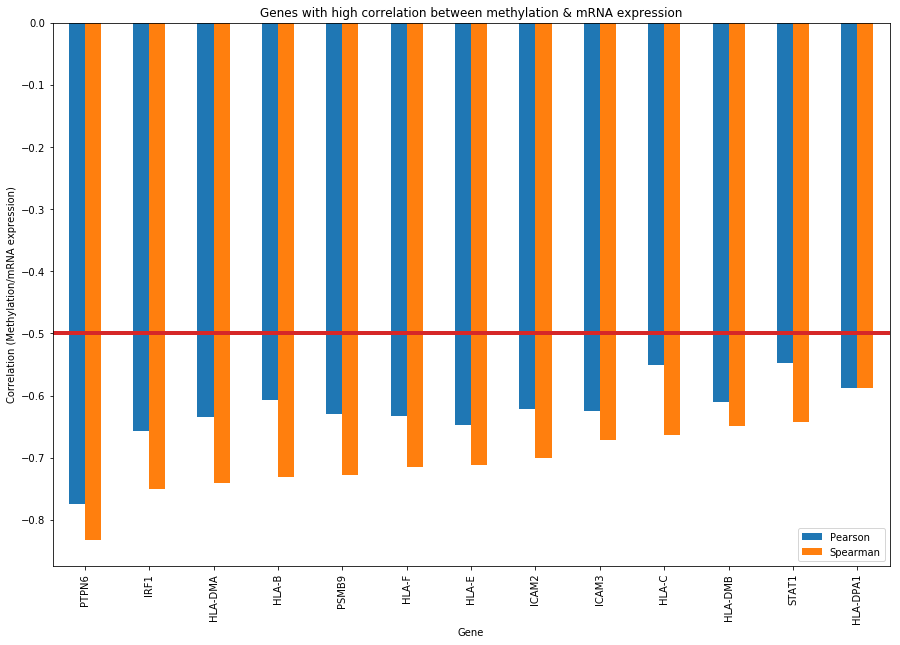

In [87]:
plt.figure()
ax = sgdf[sgdf_both].plot.bar(x='Gene', figsize=(15,10))
plt.axhline(y=-0.5, linewidth=4, color='#d62728')
ax.set_ylabel('Correlation (Methylation/mRNA expression)')
ax.set_title('Genes with high correlation between methylation & mRNA expression')
plt.show()

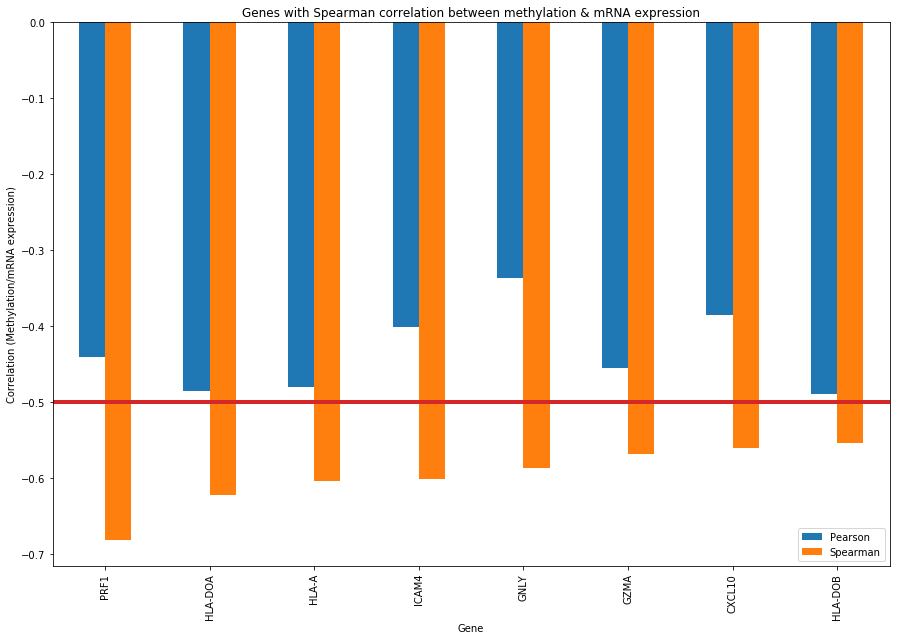

In [88]:
plt.figure()
ax = sgdf[~sgdf_both].plot.bar(x='Gene', figsize=(15,10))
plt.axhline(y=-0.5, linewidth=4, color='#d62728')
ax.set_ylabel('Correlation (Methylation/mRNA expression)')
ax.set_title('Genes with Spearman correlation between methylation & mRNA expression')
plt.show()

## Pair-genes- coexpression-mRNA (PGCM)
mRNA expression of 2 genes (A & B) which show significant correlation (Pearson and Spearman) i.e. > 0.5 or < -0.5. For this pair, see if methylation of either gene (A or B) shows significant correlation with the mRNA expression

In [90]:
mutex = pd.read_csv('./mutex_meth.csv', sep='\t')
mutex.head()

,Gene A,Gene B,p-Value,Log Odds Ratio,Association,Methylation (Pearson & Spearman both),Methylation (Spearman only)
0,IFNG,IRF1,<0.001,>3,Co-occurence,IRF1,None
1,IFNG,STAT1,<0.001,2.744,Co-occurence,None,None
2,IRF1,STAT1,<0.001,>3,Co-occurence,IRF1,STAT1
3,IFNG,PSMB9,<0.001,1.839,Co-occurence,PSMB9,None
4,IRF1,PSMB9,<0.001,2.323,Co-occurence,PSMB9 IRF1,None


## Find and remove rows where methylation of either gene does not affect co-expression of other gene
i.e. remove rows where methylation (Pearson & Spearman) and (Spearman only) have "None" values

In [119]:
no_meth_spearman_pearson = mutex['Methylation (Pearson & Spearman both)'].str.contains('None')
no_meth_spearman_only = mutex['Methylation (Spearman only)'].str.contains('None')
no_meth = no_meth_spearman_pearson & no_meth_spearman_only
meth_mutex = mutex[~no_meth]
meth_mutex.head()

,Gene A,Gene B,p-Value,Log Odds Ratio,Association,Methylation (Pearson & Spearman both),Methylation (Spearman only)
0,IFNG,IRF1,<0.001,>3,Co-occurence,IRF1,None
2,IRF1,STAT1,<0.001,>3,Co-occurence,IRF1,STAT1
3,IFNG,PSMB9,<0.001,1.839,Co-occurence,PSMB9,None
4,IRF1,PSMB9,<0.001,2.323,Co-occurence,PSMB9 IRF1,None
5,STAT1,PSMB9,<0.001,2.304,Co-occurence,PSMB9,STAT1


In [120]:
uniq = mutex['Gene A'].append(mutex['Gene B']).drop_duplicates()
df_count = uniq.to_frame(name='Gene')

## For each methylated gene, count other genes whose mRNA expression is correlated to methylated gene
MethBothCount: Count of genes whose mRNA expression correlates both with Pearson & Spearman coefficients MethOneCount: Count of genes whose mRNA expression correlates only with Spearman coefficient

In [121]:
def count_fn(gene, mutex):
    return mutex.str.contains(gene).sum()

df_count['MethBothCount'] = df_count.apply(lambda row: count_fn(row['Gene'], 
                                                                mutex['Methylation (Pearson & Spearman both)']), axis=1)
df_count['MethOneCount'] = df_count.apply(lambda row: count_fn(row['Gene'], 
                                                                mutex['Methylation (Spearman only)']), axis=1)
coexA = df_count.apply(lambda row: count_fn(row['Gene'], mutex['Gene A']), axis=1)
coexB = df_count.apply(lambda row: count_fn(row['Gene'], mutex['Gene B']), axis=1)
df_count['CoexCount'] = coexA + coexB
df_count['MethCoex%'] = 100*((df_count['MethBothCount'] + df_count['MethOneCount'])/df_count['CoexCount'])

## Sort genes based on methylation affecting coexpression
Overall percentage of Coexpression affected by methylation
Higher weightage when methylation is high(both Spearman and Pearson correlation > 0.5 or < -0.5)
Next weightage for medium methylation (only Spearman correlation > 0.5 or < -0.5)

In [122]:
df_count = df_count.sort_values(['MethBothCount', 'MethOneCount', 'MethCoex%'],
                                ascending=[False, False, False])

## Show genes whose expression is affected by this gene's methylation

In [124]:
def coex_str(gene, mutex, col):
    g1 = mutex[col].str.contains(gene)
    g1 = mutex[g1]
    coex = g1['Gene A'].append(g1['Gene B']).drop_duplicates()
    coex = coex[~coex.str.contains(gene)]
    return coex.str.cat(sep=' ')

df_count['Coex'] = df_count.apply(lambda row: coex_str(row['Gene'], mutex, 
                                                       'Methylation (Pearson & Spearman both)'), axis=1)
df_count['CoexSpearman'] = df_count.apply(lambda row: coex_str(row['Gene'], mutex, 
                                                       'Methylation (Spearman only)'), axis=1)
df_count.to_csv('pgcm_coex.txt', sep='\t', encoding='utf-8')
df_count

,Gene,MethBothCount,MethOneCount,CoexCount,MethCoex%,Coex,CoexSpearman
172,PTPN6,13,2,17,88.235294,ICAM3 ICAM2 GZMA CCR5 GZMB IFNG PRF1 IRF1 CXCL...,CXCL10 CXCL11
2,IRF1,10,5,16,93.750000,IFNG STAT1 PSMB9 CCR5 CCL4 CCL5 CXCL9 CXCL10 G...,CCL3 CXCL11 GZMB PRF1 GNLY
22,PSMB9,9,6,15,100.000000,IFNG IRF1 STAT1 CCR5 CCL4 CXCL9 CXCL10 GZMA HLA-C,CCL3 CCL5 CXCL11 GZMB PRF1 GNLY
14,ICAM3,6,3,13,69.230769,ICAM2 CCR5 CCL5 GZMA HLA-DMA PTPN6,VCAM1 CCL3 PRF1
136,PRF1,5,12,18,94.444444,IRF1 PSMB9 CCL4 HLA-DRA PTPN6,IFNG STAT1 ICAM3 CCR5 CCL3 CCL5 CXCL9 CXCL10 C...
13,ICAM2,5,1,7,85.714286,ICAM3 CCL5 GZMA HLA-DMA PTPN6,GZMB
110,GZMA,1,11,19,63.157895,PTPN6,IFNG IRF1 PSMB9 CCR5 CCL4 CCL5 CXCL9 GZMB PRF1...
153,HLA-G,1,6,8,87.500000,HLA-B,IFNG CCR5 GZMB HLA-DMA HLA-DRA PTPN6
138,HLA-C,1,0,1,100.000000,PSMB9,
145,HLA-B,1,0,2,50.000000,HLA-DRA,


## Plot genes whose methylation affects coexpression of other genes

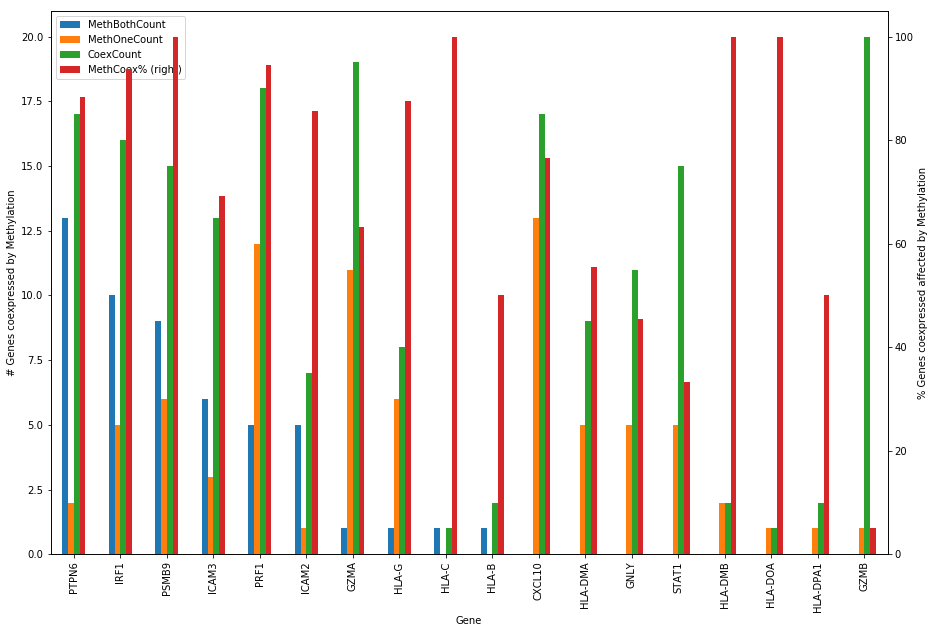

In [96]:
df2 = df_count['MethCoex%'].eq(0)
plt.figure()
ax = df_count[~df2].plot.bar(x='Gene', secondary_y=['MethCoex%'], figsize=(15,10))
ax.set_ylabel('# Genes coexpressed by Methylation')
ax.right_ax.set_ylabel('% Genes coexpressed affected by Methylation')
plt.show()

## Plot only genes where methylation does not affect coexpression

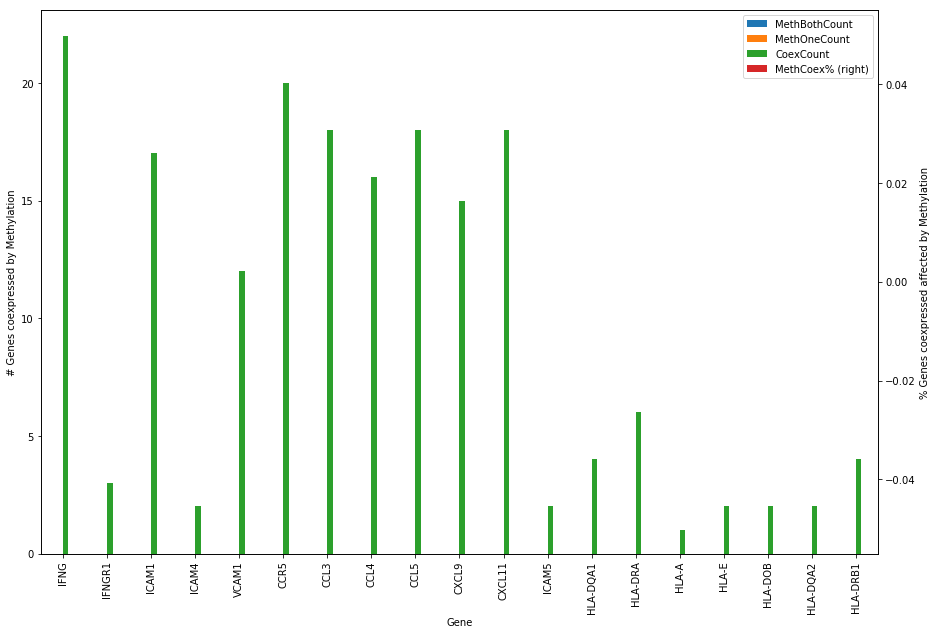

In [97]:
df2 = df_count['MethCoex%'].eq(0)
plt.figure()
ax = df_count[df2].plot.bar(x='Gene', secondary_y=['MethCoex%'], figsize=(15,10))
ax.set_ylabel('# Genes coexpressed by Methylation')
ax.right_ax.set_ylabel('% Genes coexpressed affected by Methylation')
plt.show()

In [98]:
# Get prediction interval for individual test data on linear model
# https://github.com/shahejokarian/regression-prediction-interval/blob/master/linear%20regression%20with%20prediction%20interval.ipynb
class LRPI:
    def __init__(self, normalize=False, n_jobs=1, t_value = 2.13144955):
        self.normalize = normalize
        self.n_jobs = n_jobs
        self.LR = linear_model.LinearRegression(normalize=self.normalize, n_jobs= self.n_jobs)
        self.t_value = t_value
        
    def fit(self, X_train, y_train):
        self.X_train = pd.DataFrame(X_train.values)
        self.y_train = pd.DataFrame(y_train.values)
        
        self.LR.fit(self.X_train, self.y_train)
        X_train_fit = self.LR.predict(self.X_train)
        self.MSE = np.power(self.y_train.subtract(X_train_fit), 2).sum(axis=0) / (self.X_train.shape[0] - self.X_train.shape[1] - 1)
        self.X_train.loc[:, 'const_one'] = 1
        self.XTX_inv = np.linalg.inv(np.dot(np.transpose(self.X_train.values) , self.X_train.values))
        
    def predict(self, X_test):
        self.X_test = pd.DataFrame(X_test.values)
        self.pred = self.LR.predict(self.X_test)
        self.X_test.loc[: , 'const_one'] =1
        SE = [np.dot(np.transpose(self.X_test.values[i]) , np.dot(self.XTX_inv, self.X_test.values[i]) ) for i in range(len(self.X_test)) ]
        results = pd.DataFrame(self.pred , columns=['Pred'])
        
        results.loc[:,"lower"] = results['Pred'].subtract((self.t_value)* (np.sqrt(self.MSE.values + np.multiply(SE,self.MSE.values) )),  axis=0)
        results.loc[:,"upper"] = results['Pred'].add((self.t_value)* (np.sqrt(self.MSE.values + np.multiply(SE,self.MSE.values) )),  axis=0)
        
        return results
    
def lm_predict_interval (file, X_test):
    df = pd.read_table(file, index_col=False)
    X = df.iloc[:,1]
    Y = df.iloc[:,2].apply(np.log)
    model = LRPI()
    model.fit(X, Y)
    return(model.predict(X_test))

### Predict test mRNA expression(log) based single-gene model (mRNA expression:non-log, methylation and filename with raw data)

In [99]:
# Single-gene: mRNA expression(non-log), methylation, filename which with datapoints
file = sgdf['File']

# Individual's gene measurements
# Each row: mRNA expression(log), Methylation
test = pd.read_csv('./indiv.csv')

result = lm_predict_interval(file[:1].to_string(index=False), test['Methylation'][:1])

test['Pred'] = result['Pred']
test['lower'] = result['lower']
test['upper'] = result['upper']
test.head()

,Gene,Methylation,mRNA_log,Pred,lower,upper
0,IRF1,0.80,8,5.591742,4.115518,7.067967
1,STAT1,0.10,3,NaN,NaN,NaN
2,PSMB9,0.20,4,NaN,NaN,NaN
3,ICAM2,0.05,5,NaN,NaN,NaN
4,ICAM3,0.30,6,NaN,NaN,NaN


## Single-Gene-mRNA-methylation model (SGMM)
### Predict test mRNA expression based on test methylation and single gene model
### Input: 
1. Sorted(based on correlation) single gene methylation, mRNA expression, raw data 
2. Test/Individual measured gene methylation and mRNA expression

### Output:
Array in decreasing order of importance (based on model)
1. Methylation gene, measured methylation, mRNA gene, mRNA expression(log)
2. Predicted mRNA expression(log), lower and upper bounds(log)
3. Result: True or False (if test is higher than upper mRNA expression limit)

In [104]:
def measured_meth (test, gene):
    r = test['Gene'].str.contains(gene)
    r = test[r]
    return(r['Methylation'].values[0])
def measured_mRNA (test, gene):
    r = test['Gene'].str.contains(gene)
    r = test[r]
    return(r['mRNA_log'].values[0])

# Read mRNA(non-log), methylation datapoints from file
# Create linear regression model based on it
# Given measured methylation "test", predict mRNA, upper, lower values
# Update it in result 
def mrna_predict (file, test, gene, mrnagene, result):
    df = pd.read_table(file, index_col=False)
    df = df[np.isfinite(df.iloc[:,1])]
    df = df[np.isfinite(df.iloc[:,2])]
    zr = df.iloc[:,2] == 0
    df = df[~zr]
    X = df.iloc[:,1]
    Y = df.iloc[:,2].apply(np.log)
    model = LRPI()
    model.fit(X, Y)
    X_test = pd.DataFrame.from_items([('Pred', [test])])
    pred = model.predict(X_test)

    row = result['MethGene'].str.contains(gene) & result['mRNAGene'].str.contains(mrnagene)
    row = result[row].index.values
    result.loc[row,['mRNAPred']] = pred['Pred'][0]
    result.loc[row,['PredLower']] = pred['lower'][0]
    result.loc[row,['PredUpper']] = pred['upper'][0]
    return

# Single-gene: mRNA expression(non-log), methylation(non-log), filename which with datapoints
sgdf = pd.read_csv('./sgmm.csv', sep='\t')
sgdf = sgdf.sort_values(['Spearman', 'Pearson'], ascending=[True, True])
# Consider only significant genes
sgdf_both = sgdf['Pearson'].lt(-0.5) & sgdf['Spearman'].lt(-0.5)
sgdf = sgdf[sgdf_both]
file = sgdf['File']

# To print columns in specific order, use OrderedDict
out = pd.DataFrame(columns=OrderedDict( (('MethGene',''),('MethMeasured',''),
                                          ('mRNAGene',''),('mRNAMeasured',''),('mRNAPred',''),
                                          ('PredLower',''),('PredUpper',''),('Result',''),('File','')) ))
out['MethGene'] = sgdf['Gene']
out['mRNAGene'] = sgdf['Gene']
out['File'] = sgdf['File']

# Test or Individual's gene measurements
# Each row: mMethylation, RNA expression(log)
test = pd.read_csv('./indiv.csv')
out['MethMeasured'] = out.apply(lambda row: measured_meth(test,row['MethGene']), axis=1)
out['mRNAMeasured'] = out.apply(lambda row: measured_mRNA(test,row['mRNAGene']), axis=1)

sgresult = out.apply(lambda row: mrna_predict(row['File'], row['MethMeasured'], row['MethGene'],
                                              row['mRNAGene'], out), axis=1)
out['Result'] = out['mRNAMeasured'] > out['PredUpper']

In [105]:
out

,MethGene,MethMeasured,mRNAGene,mRNAMeasured,mRNAPred,PredLower,PredUpper,Result,File
20,PTPN6,0.80,PTPN6,8,5.59174,4.11552,7.06797,True,./plots-ptpn6.txt
0,IRF1,0.80,IRF1,8,6.17775,4.53456,7.82094,True,./plots-irf1.txt
15,HLA-DMA,1.10,HLA-DMA,8,5.08363,3.42278,6.74448,True,./plots-hladma.txt
11,HLA-B,0.20,HLA-B,4,11.8966,10.0424,13.7508,False,./plots-hlab.txt
2,PSMB9,0.20,PSMB9,4,8.31582,6.52478,10.1069,False,./plots-psmb9.txt
14,HLA-F,1.00,HLA-F,7,6.19796,4.50615,7.88976,False,./plots-hlaf.txt
13,HLA-E,0.90,HLA-E,6,8.84441,7.67011,10.0187,False,./plots-hlae.txt
3,ICAM2,0.05,ICAM2,5,7.24544,5.77926,8.71162,False,./plots-icam2.txt
4,ICAM3,0.30,ICAM3,6,7.08781,6.04515,8.13046,False,./plots-icam3.txt
12,HLA-C,0.10,HLA-C,5,12.0003,10.2939,13.7067,False,./plots-hlac.txt


## Pair-Gene-coexpression-mRNA model (PGCM)
### Predict test mRNA expression based on test methylation and pair gene model
### Input: 
1. Sorted(based on correlation) pair gene methylation, mRNA expression, raw data 
2. Test/Individual measured gene methylation and mRNA expression

### Output:
Array in decreasing order of importance (based on model)
1. Methylation gene, measured methylation, mRNA gene, mRNA expression(log)
2. Predicted mRNA expression(log), lower and upper bounds(log)
3. Result: True or False (if test is higher than upper mRNA expression limit)

In [117]:
# Pair-gene: mRNA expression(non-log), methylation(non-log), filename which with datapoints
pgdf = pd.read_csv('./pgcm_both.csv', sep=',')

# Find and remove rows where methylation of either gene does not affect co-expression of other gene
# i.e. remove rows where methylation (Pearson & Spearman) and (Spearman only) have "None" values
no_meth_spearman_pearson = pgdf['Methylation (Pearson & Spearman both)'].str.contains('None')
no_meth_spearman_only = pgdf['Methylation (Spearman only)'].str.contains('None')
no_meth = no_meth_spearman_pearson & no_meth_spearman_only
pgdf = pgdf[~no_meth]

# To print columns in specific order, use OrderedDict
out = pd.DataFrame(columns=OrderedDict( (('MethGene',''),('MethMeasured',''),
                                          ('mRNAGene',''),('mRNAMeasured',''),('mRNAPred',''),
                                          ('PredLower',''),('PredUpper',''),('Result',''),('File','')) ))
out['MethGene'] = pgdf['Gene A']
out['mRNAGene'] = pgdf['Gene B']
out['File'] = pgdf['File']

# Test or Individual's gene measurements
# Each row: mMethylation, RNA expression(log)
test = pd.read_csv('./indiv.csv')
out['MethMeasured'] = out.apply(lambda row: measured_meth(test,row['MethGene']), axis=1)
out['mRNAMeasured'] = out.apply(lambda row: measured_mRNA(test,row['mRNAGene']), axis=1)

pgresult = out.apply(lambda row: mrna_predict(row['File'], row['MethMeasured'], row['MethGene'],
                                               row['mRNAGene'], out), axis=1)
out['Result'] = out['mRNAMeasured'] > out['PredUpper']

In [118]:
out

,MethGene,MethMeasured,mRNAGene,mRNAMeasured,mRNAPred,PredLower,PredUpper,Result,File
0,IRF1,0.80,IFNG,4,0.854469,-1.96822,3.67716,True,./plots-ifng-irf1.txt
1,IRF1,0.80,STAT1,3,8.37789,6.92155,9.83424,False,./plots-stat1-irf1.txt
2,PSMB9,0.20,IFNG,4,4.65949,1.57124,7.74773,False,./plots-ifng-psmb9.txt
3,PSMB9,0.20,IRF1,8,8.68088,6.82674,10.535,False,./plots-irf1-psmb9.txt
4,IRF1,0.80,PSMB9,4,5.94286,4.24666,7.63905,False,./plots-psmb9-irf1.txt
5,PSMB9,0.20,STAT1,3,10.16,8.66411,11.656,False,./plots-stat1-psmb9.txt
6,ICAM2,0.05,ICAM3,6,7.57583,6.39129,8.76036,False,./plots-icam3-icam2.txt
7,ICAM3,0.30,ICAM2,5,6.29989,4.84843,7.75136,False,./plots-icam2-icam3.txt
8,IRF1,0.80,CCR5,3,4.05002,1.77622,6.32381,False,./plots-ccr5-irf1.txt
9,PSMB9,0.20,CCR5,3,6.95539,4.51654,9.39424,False,./plots-ccr5-psmb9.txt
